In [2]:
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Github/dus_mm/')
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error 
from xgboost import XGBRegressor
import numpy as np
import pandas as pd
import utils
import glob
from matplotlib import pyplot as plt
import seaborn as sb
os.chdir('data2')

columnsX = ['freq','AX','BX','BY','CY','CX','DX','DY','AY']
columnsY = ['AX','BX','BY','CY','CX','DX','DY','AY','AQ','AL','BQ','BL','CQ','CL','DQ','DL']
columnsYout = ['AQ','AL','BQ','BL','CQ','CL','DQ','DL','X','Y','Q','L']

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
X = pd.DataFrame()
y = pd.DataFrame()
numb_files = len(glob.glob('data_output*'))
for i in glob.glob('data_output*'): 
    numb = i[11]
    if (numb == 'data_output.txt'):
        numb = ''
    y = pd.concat([y,pd.read_table(os.path.join('data_output%s.txt' % numb), header = 0, names = columnsY, 
                                   index_col = False, sep='\s+', engine='python', dtype ='float')], ignore_index = 1)
    X = pd.concat([X,pd.read_table(os.path.join('data_input%s.txt' % numb), header = 0, names = columnsX, 
                                   index_col = False, sep='\s+', engine='python', dtype ="float")], ignore_index = 1)
nelem = 64
freq_bias = [252.92, 97.13, 87.06, 57.57, 12.55, 3.40, -4.78, -11.92]
drop_ind = y.loc[(y > nelem).any(axis = 1)].index

X = utils.init_in(X, freq_bias)
y = utils.decomposition(y)

drop_ind.append(y.loc[(y == 0).all(axis = 1)].index)
X = X.drop(drop_ind).reset_index(drop=True)
y = y.drop(drop_ind).reset_index(drop=True)

In [ ]:
deltaf = y['X'] + y['Y'] + y['Q'] + y['L']
deltaf.name ='deltaf'
y  = y.drop(columns = ['X','Y','Q','L'])
y = pd.concat([y,deltaf],axis = 1)

In [ ]:
ind0 = y['deltaf'][y['deltaf'] == 0].index
X = X.drop(ind0).reset_index(drop=True)
y = y.drop(ind0).reset_index(drop=True)

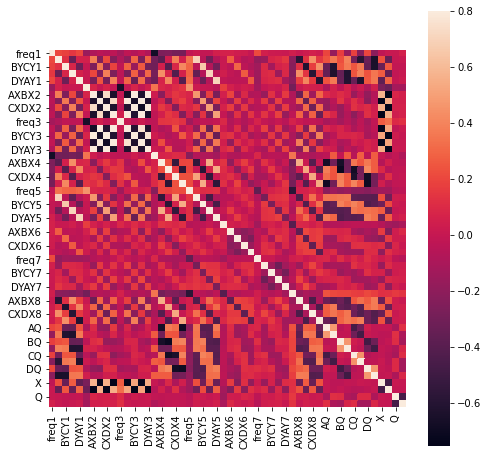

In [5]:
train_examples = pd.concat([X,y],axis = 1)
C_mat = train_examples.corr()
fig = plt.figure(figsize = (8,8))
#X1 = X.drop(columns = ['freq3'])
sb.heatmap(C_mat, vmax = .8, square = True)

In [ ]:
X.hist(figsize = (12,10))
plt.show()

In [6]:
number_train = round(len(X)*0.95)
X_train = X.loc[:number_train]
X_test = X.loc[number_train:]
X_test = X_test.reset_index(drop=True)

y_train = y.loc[:number_train]
y_test = y.loc[number_train:]
y_test = y_test.reset_index(drop=True)
input_layer = X_test.shape[1]
hidden_layer = 15
output_layer = y.shape[1]

In [9]:
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',input_dim = X.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(y.shape[1], kernel_initializer='normal',activation='linear'))

# Compile the network :
NN_model.compile(loss='mean_squared_error', optimizer='nadam', metrics=['mean_squared_error'])
NN_model.summary()

checkpoint_name = 'Weights-{epoch:03d}--{val_loss:.5f}.hdf5' 
checkpoint = ModelCheckpoint(checkpoint_name, monitor='val_loss', verbose = 1, save_best_only = True, mode ='auto')
callbacks_list = [checkpoint]

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 128)               5248      
_________________________________________________________________
dense_7 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_8 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_9 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_10 (Dense)             (None, 256)               65792     
_________________________________________________________________
dense_11 (Dense)             (None, 12)                3084      
Total params: 238,732
Trainable params: 238,732
Non-trainable params: 0
________________________________________________

In [ ]:
y

In [10]:
NN_model.fit(X_train, y_train, epochs=500, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)

Epoch 1/500
43/43 [==============================] - 12s 20ms/step - loss: 818.8167 - mean_squared_error: 818.8167 - val_loss: 647.5655 - val_mean_squared_error: 647.5655

Epoch 00001: val_loss improved from inf to 647.56549, saving model to Weights-001--647.56549.hdf5
Epoch 2/500
43/43 [==============================] - 0s 6ms/step - loss: 637.8093 - mean_squared_error: 637.8093 - val_loss: 648.9783 - val_mean_squared_error: 648.9783

Epoch 00002: val_loss did not improve from 647.56549
Epoch 3/500
43/43 [==============================] - 0s 5ms/step - loss: 638.7451 - mean_squared_error: 638.7451 - val_loss: 639.0395 - val_mean_squared_error: 639.0395

Epoch 00003: val_loss improved from 647.56549 to 639.03949, saving model to Weights-003--639.03949.hdf5
Epoch 4/500
43/43 [==============================] - 0s 6ms/step - loss: 623.5206 - mean_squared_error: 623.5206 - val_loss: 554.5714 - val_mean_squared_error: 554.5714

Epoch 00004: val_loss improved from 639.03949 to 554.57135, sav

In [11]:
wights_file = 'Weights-426--40.02239.hdf5'
NN_model.load_weights(wights_file) # load it
NN_model.compile(loss='mean_squared_error', optimizer='nadam', metrics=['mean_squared_error'])

In [ ]:
predictions = NN_model.predict(X_test)
yy = pd.DataFrame(np.round(predictions), columns = y_test.columns)

In [ ]:
y_test

In [ ]:
yy - y_test

,AQ,AL,BQ,BL,CQ,CL,DQ,DL,X,Y,Q,L
0,0.0,-1.0,-2.0,-1.0,1.0,-9.0,-2.0,-6.0,1.0,-3.0,0.0,-4.0
1,2.0,10.0,1.0,0.0,-3.0,1.0,1.0,-7.0,7.0,-1.0,32.0,-1.0
2,1.0,-1.0,-1.0,4.0,-3.0,-2.0,-1.0,-0.0,0.0,-0.0,6.0,-0.0
3,4.0,8.0,-1.0,11.0,0.0,-4.0,0.0,-0.0,-17.0,-0.0,1.0,-4.0
4,3.0,7.0,4.0,1.0,-0.0,-0.0,-0.0,0.0,1.0,5.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
85,-1.0,-0.0,0.0,-13.0,0.0,-13.0,-4.0,1.0,-4.0,-1.0,1.0,31.0
86,-2.0,-1.0,-1.0,2.0,-0.0,1.0,-6.0,5.0,-1.0,-8.0,0.0,19.0
87,-0.0,-5.0,-1.0,2.0,-1.0,0.0,0.0,1.0,-1.0,8.0,1.0,-21.0
88,0.0,-1.0,2.0,-11.0,2.0,-10.0,-2.0,-1.0,2.0,-0.0,-21.0,36.0


In [ ]:
yy - y_test

In [ ]:
yy - y_test

In [14]:
os.chdir('/content/drive/MyDrive/Github/dus_mm/data2/')
XX = pd.read_table(os.path.join('data7A-1.txt'), header = 0, names = columnsX, index_col = False, sep='\s+', engine='python', dtype ="float")
XX = utils.init_in(XX, freq_bias)
predictions = NN_model.predict(XX)
yy = np.abs(pd.DataFrame(predictions.astype('float'), columns = columnsYout))
#yy = utils.integration(yy,0.72*1.33,1.33) # перемычки 30 мкм вместо 40 мкм 1.33

In [ ]:
yy = np.abs(pd.DataFrame(np.round(predictions,0), columns = columnsYout))

In [ ]:
yy = utils.decomposition(yy)

In [16]:
np.round(yy)

,AQ,AL,BQ,BL,CQ,CL,DQ,DL,X,Y,Q,L
0,1.0,3.0,2.0,2.0,23.0,49.0,17.0,15.0,84.0,0.0,34.0,3.0


In [ ]:
XX

In [ ]:
np.round(0.72*yy*1.33)

In [ ]:
np.round(yy*1.33)

In [ ]:
np.round(yy)

In [ ]:
np.round(yy)

In [ ]:
yy.round()

In [ ]:
yy.iloc[:,:8] = 2*yy.iloc[:,:8]

In [ ]:
yy.round(2)

In [ ]:
yy = utils.integration(np.round(yy))

In [ ]:
yyy = [8,2,2,20,21,13,5,13,7,4,1,9,8,22,13,17]
yyy = pd.DataFrame([yyy], columns = columnsY,  dtype ="float")
yyy = utils.decomposition(yyy)
yyy = utils.integration(yyy)

In [ ]:
yy

In [ ]:
yy = np.abs(pd.DataFrame(np.round(predictions,1), columns = columnsYout))

In [ ]:
yy = utils.integration(predictions, 0.73)

In [ ]:
train_X, val_X, train_y, val_y = train_test_split(X_train, y_train, test_size = 0.25, random_state = 14)

In [ ]:
model = RandomForestRegressor()
model.fit(train_X,train_y)

# Get the mean absolute error on the validation data
predicted = model.predict(val_X)
MAE = mean_absolute_error(val_y , predicted)
print('Random forest validation MAE = ', MAE)

In [ ]:
help(XGBRegressor)

In [ ]:
XGBModel = XGBRegressor()
XGBModel.fit(train_X,train_y , verbose=False)

# Get the mean absolute error on the validation data :
XGBpredictions = XGBModel.predict(val_X)
MAE = mean_absolute_error(val_y , XGBpredictions)
print('XGBoost validation MAE = ',MAE)

In [ ]:
from sklearn.datasets import make_regression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import GradientBoostingRegressor
#X, y = make_regression(n_samples=10, n_targets=3, random_state=1)
MultiOutputRegressor(GradientBoostingRegressor(random_state=0)).fit(X_train, y_train).predict(X_test)

In [ ]:
yy = pd.DataFrame(np.round(_),columns = y_test.columns)

In [ ]:
y_test

In [ ]:
yy

In [ ]:
y_test - yy